# Hierarchical Agglomerative Clustering (HAC)

<b>Objective</b> - Use HAC to group NBA players based on their role / playing style

- <b>Metrics to use for filtering / adjustments:</b>
    - Games played - only select players that played in at least half of the regular season (31+ games)
    - Minutes per game - only select players that played for at least 10 mins per game. Also, use it to calculate per minute statistics


- <b>Metrics to use for clustering (adjust to make per minute). Also, we take shots attempted rather than shots made:</b>
    - SHOT DISTANCE (5FT)
        - Less Than 8 ft.
        - 8-16 ft.
        - 16-24 ft.
        - 24+ ft.
        - Back Court Shot
    - SHOT AREA
        - Restricted Area	
        - In The Paint (Non-RA)
        - Mid-Range
        - Left Corner 3
        - Right Corner 3
        - Above the Break 3
        - Backcourt
    - SHOT TYPE SUMMARY
        - Alley Oop
        - Bank Shot
        - Dunk
        - Fadeaway
        - Finger Roll
        - Hook Shot
        - Jump Shot
        - Layup
        - Tip Shot
    - Assists
    - Blocks
    - Offensive Rebounds
    - Defensive Rebounds
    - Steals

## 0. Import Libraries

In [561]:
import pandas as pd # For handling data
import time # For setting up time delays between queries
from nba_api.stats.static import players # For player list; "pip install nba_api"
from nba_api.stats.endpoints import playerdashboardbygeneralsplits # For standard player tats
from nba_api.stats.endpoints import playerdashboardbyshootingsplits # For more detailed shooting stats
from progressbar import ProgressBar # For showing progress of iterations
import matplotlib.pyplot as plt # For plotting histograms and bar charts
import matplotlib as mpl # For plotting bar charts
from sklearn.preprocessing import MinMaxScaler # For rescaling metrics to fit 0 to 1 range
from sklearn.cluster import AgglomerativeClustering # For HAC clustering
import scipy.cluster.hierarchy as sch # For HAC Denddrogram

# Adjust pandas options
pd.options.display.max_columns=500 # Option to display all columns in our DataFrames

## 1. Collect Data

#### Get Current NBA Player List

In [110]:
# Below returns a list of dictionaries
nba_players=players.get_players()

# Let's create a Pandas DataFrame using extracted list of dictionaries
df_nba_players=pd.DataFrame(nba_players)

# Keep only current players
df_nba_players=df_nba_players[df_nba_players['is_active']==True]

# Print DataFrame
df_nba_players

,id,full_name,first_name,last_name,is_active
21,203500,Steven Adams,Steven,Adams,True
23,1628389,Bam Adebayo,Bam,Adebayo,True
41,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True
48,1629734,Kyle Alexander,Kyle,Alexander,True
50,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True
...,...,...,...,...,...
4477,201152,Thaddeus Young,Thaddeus,Young,True
4479,1629027,Trae Young,Trae,Young,True
4482,203469,Cody Zeller,Cody,Zeller,True
4496,1627790,Ante Zizic,Ante,Zizic,True


#### Create a list of player ids

In [127]:
pid_list=list(df_nba_players['id'])
#pid_list

[203500,
 1628389,
 200746,
 1629734,
 1629638,
 1628960,
 1628386,
 1628443,
 202329,
 1626147,
 203937,
 201583,
 203507,
 1628961,
 203648,
 2546,
 1628384,
 1627853,
 2772,
 201571,
 1629028,
 1628407,
 1628963,
 1628366,
 1628964,
 200826,
 203084,
 1629628,
 203115,
 1628966,
 201587,
 203382,
 203145,
 1629647,
 203078,
 1627736,
 201158,
 1628395,
 1627761,
 1627733,
 202722,
 201976,
 203920,
 1629048,
 202687,
 202357,
 202339,
 203992,
 202711,
 1629626,
 1628413,
 1629648,
 1629067,
 1626164,
 1628449,
 1628968,
 1629065,
 202340,
 1628396,
 1629714,
 1629649,
 1628969,
 1628970,
 1629052,
 1629151,
 1627763,
 1628415,
 1628971,
 1627759,
 1629650,
 1628425,
 1629718,
 1628972,
 1628973,
 1628418,
 203493,
 203504,
 202692,
 1629126,
 202710,
 203998,
 1629719,
 203484,
 1628427,
 203991,
 201960,
 1628975,
 1713,
 1628976,
 203487,
 1627936,
 1626161,
 2199,
 201163,
 1629597,
 1629185,
 1627737,
 1629109,
 1629634,
 203903,
 1629651,
 1629598,
 1628499,
 1629599,
 1628381

#### Get Stadard Player Starts for  2019-20 Regular Season

In [128]:
# Create empty DataFrame
player_pergame=pd.DataFrame()

# Set up progressbar
pbar=ProgressBar()

# Extract standard player stats
for pid in pbar(pid_list):
    player_stats=playerdashboardbygeneralsplits.PlayerDashboardByGeneralSplits(player_id=pid,
                                                                          season='2019-20', 
                                                                          season_type_playoffs='Regular Season', 
                                                                          per_mode_detailed='PerGame')
    # Take overall statistics
    player_pg=player_stats.get_data_frames()[0]

    # Insert Player ID to be used for data merging later on
    player_pg.insert(0, 'id', pid)

    # Keep only the first 30 columns
    player_pg=player_pg.iloc[:,0:29]
    
    # Append
    player_pergame=pd.concat([player_pergame, player_pg], ignore_index=True, axis=0, sort=False)
    

100% |########################################################################|


In [140]:
# Save a copy to csv
#player_pergame.to_csv('NBA_Player_Basic_Stats.csv', index=False)

In [604]:
# Print resulting DataFrame
player_pergame

,id,GROUP_SET,GROUP_VALUE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
0,203500,Overall,2019-20,63,40,23,0.635,26.7,4.5,7.6,0.592,0.0,0.0,0.333,1.9,3.2,0.582,3.3,6.0,9.3,2.3,1.5,0.8,1.1,0.5,1.9,3.3,10.9,2.4
1,1628389,Overall,2019-20,72,44,28,0.611,33.6,6.1,11.0,0.557,0.0,0.2,0.143,3.7,5.3,0.691,2.4,7.8,10.2,5.1,2.8,1.1,1.3,0.8,2.5,4.5,15.9,3.4
2,200746,Overall,2019-20,53,23,30,0.434,33.1,7.4,15.0,0.493,1.2,3.0,0.389,3.0,3.6,0.827,1.9,5.5,7.4,2.4,1.4,0.7,1.6,0.4,2.4,3.1,18.9,-2.4
3,1629734,Overall,2019-20,2,0,2,0.000,6.7,0.5,1.0,0.500,0.0,0.0,0.000,0.0,0.0,0.000,1.0,0.5,1.5,0.0,0.5,0.0,0.0,0.0,0.5,0.0,1.0,-1.5
4,1629638,Overall,2019-20,47,19,28,0.404,12.6,2.1,5.7,0.368,1.0,2.8,0.346,0.5,0.8,0.676,0.2,1.6,1.8,1.9,1.1,0.4,0.2,0.4,1.2,1.0,5.7,-1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,201152,Overall,2019-20,64,22,42,0.344,24.9,4.2,9.4,0.448,1.2,3.5,0.356,0.7,1.1,0.583,1.5,3.5,4.9,1.8,1.6,1.4,0.4,0.7,2.1,1.5,10.3,-3.3
503,1629027,Overall,2019-20,60,18,42,0.300,35.3,9.1,20.8,0.437,3.4,9.5,0.361,8.0,9.3,0.860,0.5,3.7,4.3,9.3,4.8,1.1,0.1,1.3,1.7,7.7,29.6,-3.8
504,203469,Overall,2019-20,58,18,40,0.310,23.1,4.3,8.3,0.524,0.3,1.3,0.240,2.1,3.1,0.682,2.8,4.3,7.1,1.5,1.3,0.7,0.4,0.8,2.4,3.1,11.1,-3.8
505,1627790,Overall,2019-20,22,4,18,0.182,10.0,1.9,3.3,0.569,0.0,0.0,0.000,0.6,0.9,0.737,0.8,2.2,3.0,0.3,0.5,0.3,0.2,0.2,1.2,0.9,4.4,0.6


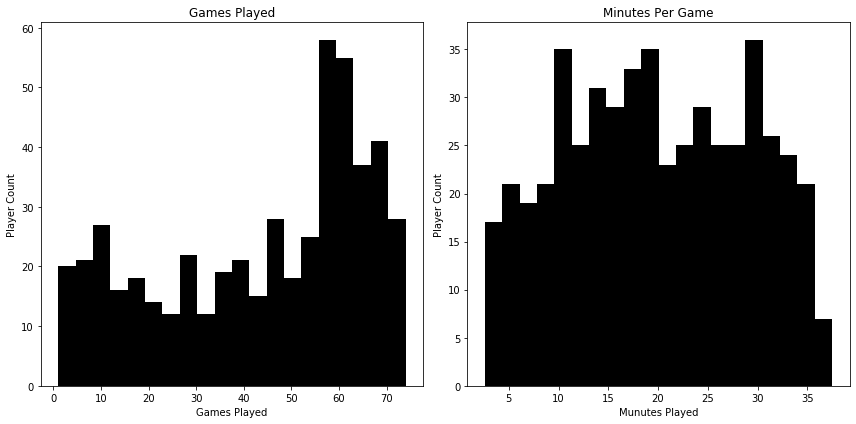

In [194]:
# Check distributions of games played and minutes played per game
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(12,6))

axs[0].hist(player_pergame['GP'], bins=20, color='black')
axs[1].hist(player_pergame['MIN'], bins=20, color='black')

axs[0].set(title='Games Played', xlabel='Games Played', ylabel='Player Count')
axs[1].set(title='Minutes Per Game', xlabel='Munutes Played', ylabel='Player Count')
plt.show()

##### Select players for Clustering

In [530]:
# Select Players that played at least half of the regular season games (31) 
# And on average played at least 10 minutes per game
Selected_players=player_pergame[(player_pergame['GP']>=31) & (player_pergame['MIN']>=10)]

##### Remove some other not needed columns

In [537]:
# Selecting columns for Clustering
Selected_players_data=Selected_players.iloc[:,[0, 3, 7, 17, 18, 20, 22, 23]]
# Convert Games Played to integer
Selected_players_data['GP']=Selected_players_data['GP'].astype(int)
# Show column data types
Selected_players_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 506
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      346 non-null    int64  
 1   GP      346 non-null    int64  
 2   MIN     346 non-null    float64
 3   OREB    346 non-null    float64
 4   DREB    346 non-null    float64
 5   AST     346 non-null    float64
 6   STL     346 non-null    float64
 7   BLK     346 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 24.3 KB


/Users/solclover/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### Create a revised player id list that contains only selected players for clustering

In [339]:
pid_list_rev=list(Selected_players_data['id'])
pid_list_rev

[203500,
 1628389,
 200746,
 1629638,
 1628960,
 1628386,
 203937,
 203507,
 2546,
 1628384,
 1627853,
 2772,
 201571,
 1629028,
 1628407,
 1628366,
 1628964,
 203084,
 1629628,
 203115,
 1628966,
 203382,
 203145,
 1629647,
 203078,
 1627736,
 201158,
 1627761,
 202722,
 201976,
 203920,
 202687,
 202357,
 202339,
 203992,
 202711,
 1629067,
 1626164,
 1628449,
 1629065,
 202340,
 1628396,
 1628969,
 1628970,
 1627763,
 1628415,
 1628971,
 1627759,
 1628425,
 1628972,
 1628973,
 1628418,
 203504,
 202692,
 202710,
 203484,
 203991,
 1628975,
 1713,
 1628976,
 203487,
 1627936,
 1626161,
 201163,
 1627737,
 1629109,
 1629634,
 203903,
 1628381,
 201144,
 1626192,
 1626188,
 203496,
 203459,
 1628470,
 203109,
 1629633,
 203552,
 203584,
 203076,
 1629056,
 201942,
 203473,
 203521,
 1628978,
 1627767,
 1628977,
 203476,
 203915,
 1629029,
 1629652,
 1628422,
 1629635,
 201609,
 203083,
 1627739,
 201961,
 203954,
 203516,
 203957,
 202324,
 1628390,
 1628981,
 1627812,
 1627827,
 16278

##### Define a function that will make data extraction code neater as we won't need to repeat same steps 3 times

In [201]:
def sht(pids, tid):
    # Take Shooting stats by shot type
    df=player_shoot_stats.get_data_frames()[tid]
    # Only keep shot type and FGA
    df=df.iloc[:,[1,3]]
    # Transpose data
    df=df.T
    # Reset index
    df=df.reset_index(drop=True)
    # Take the first row and make it column names
    df.columns = df.iloc[0]
    # Remove first row as it is redundand
    df = df[1:]
    # Insert Player ID to be used for data merging later on
    df.insert(0, 'id', pids)
    return df

#### Extract shooting statistics

In [203]:
# Create empty DataFrame
shoot_stats_dist=pd.DataFrame()
shoot_stats_area=pd.DataFrame()
shoot_stats_type=pd.DataFrame()

# Set up progressbar
pbar=ProgressBar()

# Extract shooting
for pid in pbar(pid_list_rev):
    player_shoot_stats=playerdashboardbyshootingsplits.PlayerDashboardByShootingSplits(player_id=pid,
                                                                          season='2019-20', 
                                                                          season_type_playoffs='Regular Season', 
                                                                          per_mode_detailed='PerGame')
    # Shooting Distance
    shoot_stats_dist_tmp=sht(pid, 2)
    # Shooting Area
    shoot_stats_area_tmp=sht(pid, 3)
    # Shooting Type
    shoot_stats_type_tmp=sht(pid, 5)
    
    # Append
    shoot_stats_dist=pd.concat([shoot_stats_dist, shoot_stats_dist_tmp], ignore_index=True, axis=0, sort=False)
    shoot_stats_area=pd.concat([shoot_stats_area, shoot_stats_area_tmp], ignore_index=True, axis=0, sort=False)
    shoot_stats_type=pd.concat([shoot_stats_type, shoot_stats_type_tmp], ignore_index=True, axis=0, sort=False)
    

100% |########################################################################|


In [207]:
# Save a copy to csv
#shoot_stats_dist.to_csv('NBA_Player_Shooting_Stats_Dist.csv', index=False)
#shoot_stats_area.to_csv('NBA_Player_Shooting_Stats_Area.csv', index=False)
#shoot_stats_type.to_csv('NBA_Player_Shooting_Stats_Type.csv', index=False)

#### Check downloaded DataFrames

In [538]:
shoot_stats_dist

,id,Less Than 8 ft.,8-16 ft.,16-24 ft.,24+ ft.,Back Court Shot
0,203500,398,76,1,2,1
1,1628389,573,159,44,13,1
2,200746,240,202,194,156,1
3,1629638,101,24,8,129,4
4,1628960,71,38,1,141,0
...,...,...,...,...,...,...
341,1626153,240,35,9,124,3
342,201152,327,35,17,220,2
343,1629027,382,237,62,567,1
344,203469,376,26,2,75,0


In [205]:
shoot_stats_area

,id,Restricted Area,In The Paint (Non-RA),Mid-Range,Left Corner 3,Right Corner 3,Above the Break 3,Backcourt
0,203500,282,179,14,0,1,1,1
1,1628389,434,248,94,4,4,5,1
2,200746,185,99,352,21,8,127,1
3,1629638,78,36,19,12,14,104,3
4,1628960,43,51,16,28,10,103,0
...,...,...,...,...,...,...,...,...
341,1626153,180,88,16,12,14,98,3
342,201152,227,124,28,67,28,125,2
343,1629027,265,307,109,6,15,547,0
344,203469,317,82,5,1,3,71,0


In [206]:
shoot_stats_type

,id,Alley Oop,Bank Shot,Dunk,Fadeaway,Finger Roll,Hook Shot,Jump Shot,Layup,Tip Shot
0,203500,10,7,84,0,7,128,71,195,51
1,1628389,44,17,173,3,24,74,284,257,27
2,200746,8,7,35,72,26,47,513,145,40
3,1629638,0,7,2,2,12,0,175,88,0
4,1628960,2,4,11,0,5,3,202,35,1
...,...,...,...,...,...,...,...,...,...,...
341,1626153,1,23,9,9,23,5,208,187,15
342,201152,1,12,29,4,11,74,305,192,22
343,1629027,0,27,0,4,56,0,960,289,2
344,203469,3,6,67,6,8,30,132,247,57


## 2. Prepare Data for Clustering

#### Merge All 4 tables together

In [379]:
# Do right join to keep only the selected players
Player_data=pd.merge(df_nba_players, Selected_players_data, how='right', on='id')

# Merge all other dataframes 
dfs=[shoot_stats_dist, shoot_stats_area, shoot_stats_type]
for dfi in dfs: 
    dfi=dfi.astype(int) # Converting objects to integers
    Player_data=pd.merge(Player_data, dfi, how='left', on='id')
    
# Show resulting DataFrame
Player_data

,id,full_name,first_name,last_name,is_active,GP,MIN,OREB,DREB,AST,STL,BLK,Less Than 8 ft.,8-16 ft.,16-24 ft.,24+ ft.,Back Court Shot,Restricted Area,In The Paint (Non-RA),Mid-Range,Left Corner 3,Right Corner 3,Above the Break 3,Backcourt,Alley Oop,Bank Shot,Dunk,Fadeaway,Finger Roll,Hook Shot,Jump Shot,Layup,Tip Shot
0,203500,Steven Adams,Steven,Adams,True,63,26.7,3.3,6.0,2.3,0.8,1.1,398,76,1,2,1,282,179,14,0,1,1,1,10,7,84,0,7,128,71,195,51
1,1628389,Bam Adebayo,Bam,Adebayo,True,72,33.6,2.4,7.8,5.1,1.1,1.3,573,159,44,13,1,434,248,94,4,4,5,1,44,17,173,3,24,74,284,257,27
2,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True,53,33.1,1.9,5.5,2.4,0.7,1.6,240,202,194,156,1,185,99,352,21,8,127,1,8,7,35,72,26,47,513,145,40
3,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True,47,12.6,0.2,1.6,1.9,0.4,0.2,101,24,8,129,4,78,36,19,12,14,104,3,0,7,2,2,12,0,175,88,0
4,1628960,Grayson Allen,Grayson,Allen,True,38,18.9,0.2,2.0,1.4,0.3,0.1,71,38,1,141,0,43,51,16,28,10,103,0,2,4,11,0,5,3,202,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,1626153,Delon Wright,Delon,Wright,True,73,21.5,1.0,2.9,3.3,1.2,0.3,240,35,9,124,3,180,88,16,12,14,98,3,1,23,9,9,23,5,208,187,15
342,201152,Thaddeus Young,Thaddeus,Young,True,64,24.9,1.5,3.5,1.8,1.4,0.4,327,35,17,220,2,227,124,28,67,28,125,2,1,12,29,4,11,74,305,192,22
343,1629027,Trae Young,Trae,Young,True,60,35.3,0.5,3.7,9.3,1.1,0.1,382,237,62,567,1,265,307,109,6,15,547,0,0,27,0,4,56,0,960,289,2
344,203469,Cody Zeller,Cody,Zeller,True,58,23.1,2.8,4.3,1.5,0.7,0.4,376,26,2,75,0,317,82,5,1,3,71,0,3,6,67,6,8,30,132,247,57


Naturally, there is a strong correlation between minutes played and the stats such as shots attempted etc. Hence, to avoid clusters being formed based on how long the player spends on a court, we will divide it by minutes played so we have per minute played stats

#### List of columns that will need to be averaged

In [378]:
# Game averages only need to be divided by average minutes played
avg_metrics=['OREB', 'DREB', 'AST', 'STL', 'BLK']

# Regular season totals will need to be divided by games played and average minutes played
tot_metrics=list(list(Player_data.columns)[12:33])

# Add the two lists together for easier processing later
com_met_list=avg_metrics+tot_metrics

# Show resulting list
com_met_list

['OREB',
 'DREB',
 'AST',
 'STL',
 'BLK',
 'Less Than 8 ft.',
 '8-16 ft.',
 '16-24 ft.',
 '24+ ft.',
 'Back Court Shot',
 'Restricted Area',
 'In The Paint (Non-RA)',
 'Mid-Range',
 'Left Corner 3',
 'Right Corner 3',
 'Above the Break 3',
 'Backcourt',
 'Alley Oop',
 'Bank Shot',
 'Dunk',
 'Fadeaway',
 'Finger Roll',
 'Hook Shot',
 'Jump Shot',
 'Layup',
 'Tip Shot']

#### Create a DataFrame with per game statistics

In [382]:
# First, make total metrics to be per game and save a copy of df for later usage
for col in tot_metrics:
    Player_data[col]=(Player_data[col]/Player_data['GP']).astype(float)

# Make a copy of a dataframe
Player_data_orig=Player_data.copy()

# Show Resulting DataFrame
Player_data_orig

,id,full_name,first_name,last_name,is_active,GP,MIN,OREB,DREB,AST,STL,BLK,Less Than 8 ft.,8-16 ft.,16-24 ft.,24+ ft.,Back Court Shot,Restricted Area,In The Paint (Non-RA),Mid-Range,Left Corner 3,Right Corner 3,Above the Break 3,Backcourt,Alley Oop,Bank Shot,Dunk,Fadeaway,Finger Roll,Hook Shot,Jump Shot,Layup,Tip Shot
0,203500,Steven Adams,Steven,Adams,True,63,26.7,3.3,6.0,2.3,0.8,1.1,6.317460,1.206349,0.015873,0.031746,0.015873,4.476190,2.841270,0.222222,0.000000,0.015873,0.015873,0.015873,0.158730,0.111111,1.333333,0.000000,0.111111,2.031746,1.126984,3.095238,0.809524
1,1628389,Bam Adebayo,Bam,Adebayo,True,72,33.6,2.4,7.8,5.1,1.1,1.3,7.958333,2.208333,0.611111,0.180556,0.013889,6.027778,3.444444,1.305556,0.055556,0.055556,0.069444,0.013889,0.611111,0.236111,2.402778,0.041667,0.333333,1.027778,3.944444,3.569444,0.375000
2,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True,53,33.1,1.9,5.5,2.4,0.7,1.6,4.528302,3.811321,3.660377,2.943396,0.018868,3.490566,1.867925,6.641509,0.396226,0.150943,2.396226,0.018868,0.150943,0.132075,0.660377,1.358491,0.490566,0.886792,9.679245,2.735849,0.754717
3,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True,47,12.6,0.2,1.6,1.9,0.4,0.2,2.148936,0.510638,0.170213,2.744681,0.085106,1.659574,0.765957,0.404255,0.255319,0.297872,2.212766,0.063830,0.000000,0.148936,0.042553,0.042553,0.255319,0.000000,3.723404,1.872340,0.000000
4,1628960,Grayson Allen,Grayson,Allen,True,38,18.9,0.2,2.0,1.4,0.3,0.1,1.868421,1.000000,0.026316,3.710526,0.000000,1.131579,1.342105,0.421053,0.736842,0.263158,2.710526,0.000000,0.052632,0.105263,0.289474,0.000000,0.131579,0.078947,5.315789,0.921053,0.026316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,1626153,Delon Wright,Delon,Wright,True,73,21.5,1.0,2.9,3.3,1.2,0.3,3.287671,0.479452,0.123288,1.698630,0.041096,2.465753,1.205479,0.219178,0.164384,0.191781,1.342466,0.041096,0.013699,0.315068,0.123288,0.123288,0.315068,0.068493,2.849315,2.561644,0.205479
342,201152,Thaddeus Young,Thaddeus,Young,True,64,24.9,1.5,3.5,1.8,1.4,0.4,5.109375,0.546875,0.265625,3.437500,0.031250,3.546875,1.937500,0.437500,1.046875,0.437500,1.953125,0.031250,0.015625,0.187500,0.453125,0.062500,0.171875,1.156250,4.765625,3.000000,0.343750
343,1629027,Trae Young,Trae,Young,True,60,35.3,0.5,3.7,9.3,1.1,0.1,6.366667,3.950000,1.033333,9.450000,0.016667,4.416667,5.116667,1.816667,0.100000,0.250000,9.116667,0.000000,0.000000,0.450000,0.000000,0.066667,0.933333,0.000000,16.000000,4.816667,0.033333
344,203469,Cody Zeller,Cody,Zeller,True,58,23.1,2.8,4.3,1.5,0.7,0.4,6.482759,0.448276,0.034483,1.293103,0.000000,5.465517,1.413793,0.086207,0.017241,0.051724,1.224138,0.000000,0.051724,0.103448,1.155172,0.103448,0.137931,0.517241,2.275862,4.258621,0.982759


In [383]:
# Divide by minutes played to get minute average statistics
for col in com_met_list:
    Player_data[col]=(Player_data[col]/Player_data['MIN']).astype(float)
    
# Show resulting DataFrame
Player_data

,id,full_name,first_name,last_name,is_active,GP,MIN,OREB,DREB,AST,STL,BLK,Less Than 8 ft.,8-16 ft.,16-24 ft.,24+ ft.,Back Court Shot,Restricted Area,In The Paint (Non-RA),Mid-Range,Left Corner 3,Right Corner 3,Above the Break 3,Backcourt,Alley Oop,Bank Shot,Dunk,Fadeaway,Finger Roll,Hook Shot,Jump Shot,Layup,Tip Shot
0,203500,Steven Adams,Steven,Adams,True,63,26.7,0.123596,0.224719,0.086142,0.029963,0.041199,0.236609,0.045182,0.000594,0.001189,0.000594,0.167648,0.106415,0.008323,0.000000,0.000594,0.000594,0.000594,0.005945,0.004161,0.049938,0.000000,0.004161,0.076095,0.042209,0.115927,0.030319
1,1628389,Bam Adebayo,Bam,Adebayo,True,72,33.6,0.071429,0.232143,0.151786,0.032738,0.038690,0.236855,0.065724,0.018188,0.005374,0.000413,0.179398,0.102513,0.038856,0.001653,0.001653,0.002067,0.000413,0.018188,0.007027,0.071511,0.001240,0.009921,0.030589,0.117394,0.106233,0.011161
2,200746,LaMarcus Aldridge,LaMarcus,Aldridge,True,53,33.1,0.057402,0.166163,0.072508,0.021148,0.048338,0.136807,0.115146,0.110585,0.088924,0.000570,0.105455,0.056433,0.200650,0.011971,0.004560,0.072394,0.000570,0.004560,0.003990,0.019951,0.041042,0.014821,0.026791,0.292424,0.082654,0.022801
3,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True,47,12.6,0.015873,0.126984,0.150794,0.031746,0.015873,0.170550,0.040527,0.013509,0.217832,0.006754,0.131712,0.060790,0.032084,0.020263,0.023641,0.175616,0.005066,0.000000,0.011820,0.003377,0.003377,0.020263,0.000000,0.295508,0.148598,0.000000
4,1628960,Grayson Allen,Grayson,Allen,True,38,18.9,0.010582,0.105820,0.074074,0.015873,0.005291,0.098858,0.052910,0.001392,0.196324,0.000000,0.059872,0.071011,0.022278,0.038986,0.013924,0.143414,0.000000,0.002785,0.005569,0.015316,0.000000,0.006962,0.004177,0.281259,0.048733,0.001392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,1626153,Delon Wright,Delon,Wright,True,73,21.5,0.046512,0.134884,0.153488,0.055814,0.013953,0.152915,0.022300,0.005734,0.079006,0.001911,0.114686,0.056069,0.010194,0.007646,0.008920,0.062440,0.001911,0.000637,0.014654,0.005734,0.005734,0.014654,0.003186,0.132526,0.119146,0.009557
342,201152,Thaddeus Young,Thaddeus,Young,True,64,24.9,0.060241,0.140562,0.072289,0.056225,0.016064,0.205196,0.021963,0.010668,0.138052,0.001255,0.142445,0.077811,0.017570,0.042043,0.017570,0.078439,0.001255,0.000628,0.007530,0.018198,0.002510,0.006903,0.046436,0.191391,0.120482,0.013805
343,1629027,Trae Young,Trae,Young,True,60,35.3,0.014164,0.104816,0.263456,0.031161,0.002833,0.180359,0.111898,0.029273,0.267705,0.000472,0.125118,0.144948,0.051464,0.002833,0.007082,0.258263,0.000000,0.000000,0.012748,0.000000,0.001889,0.026440,0.000000,0.453258,0.136449,0.000944
344,203469,Cody Zeller,Cody,Zeller,True,58,23.1,0.121212,0.186147,0.064935,0.030303,0.017316,0.280639,0.019406,0.001493,0.055979,0.000000,0.236602,0.061203,0.003732,0.000746,0.002239,0.052993,0.000000,0.002239,0.004478,0.050007,0.004478,0.005971,0.022391,0.098522,0.184356,0.042544


#### Use Min-Max scaler to scale metrics so they all range from 0 to 1

In [390]:
# Set up scalar
scaler = MinMaxScaler()

# Apply Min-Max Scalar
X=scaler.fit_transform(Player_data.iloc[:,7:33])

# Print Array to be used for Clustering
X

array([[0.73624464, 0.5514003 , 0.22589831, ..., 0.0761917 , 0.38996367,
        0.51402779],
       [0.4167894 , 0.57356077, 0.46943224, ..., 0.22321749, 0.35342942,
        0.18921703],
       [0.33089357, 0.37660639, 0.17531395, ..., 0.56549232, 0.26455584,
        0.38656663],
       ...,
       [0.06611956, 0.19348019, 0.88372413, ..., 0.88000525, 0.46731711,
        0.0160093 ],
       [0.72164948, 0.43626026, 0.14722037, ..., 0.18631291, 0.64788191,
        0.72127872],
       [0.87796952, 0.65931213, 0.128105  , ..., 0.06155089, 0.45375116,
        0.94699926]])

## 3. Clustering

##### Plot a dendrogram to decide on the optimal number of clusters

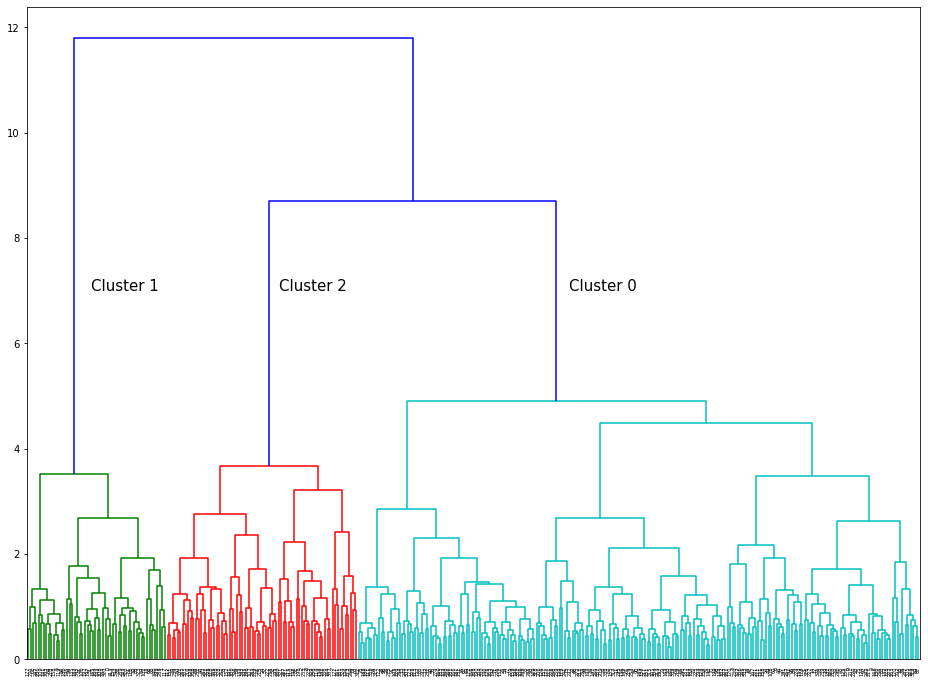

In [553]:
# Create a chart
plt.figure(figsize=(16,12))

# Draw Dendrogram
dendrogram = sch.dendrogram(sch.linkage(X, method='ward')) 

# Add annotations for clarity for cluster namings (note, are not in order)
plt.annotate('Cluster 1', xy=(250, 7), xytext=(250, 7), size=15)
plt.annotate('Cluster 2', xy=(975, 7), xytext=(975, 7), size=15)
plt.annotate('Cluster 0', xy=(2100, 7), xytext=(2100, 7), size=15) 

plt.show()

To pick the optimal number of clusters, we need to identify the area in the chart with the highest vertical distance that does not intersect with any clusters. In this scenario the area with the highest verticvle distance is where I placed cluster names. Since it crosses 3 vertical lines, 3 is the optimal number of clusters.

##### Fit the Hierarchical Agglomerative Clustering (HAC) and create labels array

In [554]:
# Fit HAC on our data
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(X)
# Take cluster labels
labels = model.labels_

# Display labels array
labels

array([1, 1, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0,
       2, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0,
       2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1,
       2, 0, 2, 0, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2, 2, 0,
       1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 1,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0,
       0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1,
       1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0,
       2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 0,

## 4. Analyze Clusters

#### Insert Cluster lables into original player data

In [556]:
# Insert cluster labels
Player_data_orig.insert(1, 'cluster', labels)

# Show resulting DataFrame
Player_data_orig

,id,cluster,full_name,first_name,last_name,is_active,GP,MIN,OREB,DREB,AST,STL,BLK,Less Than 8 ft.,8-16 ft.,16-24 ft.,24+ ft.,Back Court Shot,Restricted Area,In The Paint (Non-RA),Mid-Range,Left Corner 3,Right Corner 3,Above the Break 3,Backcourt,Alley Oop,Bank Shot,Dunk,Fadeaway,Finger Roll,Hook Shot,Jump Shot,Layup,Tip Shot
0,203500,1,Steven Adams,Steven,Adams,True,63,26.7,3.3,6.0,2.3,0.8,1.1,6.317460,1.206349,0.015873,0.031746,0.015873,4.476190,2.841270,0.222222,0.000000,0.015873,0.015873,0.015873,0.158730,0.111111,1.333333,0.000000,0.111111,2.031746,1.126984,3.095238,0.809524
1,1628389,1,Bam Adebayo,Bam,Adebayo,True,72,33.6,2.4,7.8,5.1,1.1,1.3,7.958333,2.208333,0.611111,0.180556,0.013889,6.027778,3.444444,1.305556,0.055556,0.055556,0.069444,0.013889,0.611111,0.236111,2.402778,0.041667,0.333333,1.027778,3.944444,3.569444,0.375000
2,200746,2,LaMarcus Aldridge,LaMarcus,Aldridge,True,53,33.1,1.9,5.5,2.4,0.7,1.6,4.528302,3.811321,3.660377,2.943396,0.018868,3.490566,1.867925,6.641509,0.396226,0.150943,2.396226,0.018868,0.150943,0.132075,0.660377,1.358491,0.490566,0.886792,9.679245,2.735849,0.754717
3,1629638,0,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True,47,12.6,0.2,1.6,1.9,0.4,0.2,2.148936,0.510638,0.170213,2.744681,0.085106,1.659574,0.765957,0.404255,0.255319,0.297872,2.212766,0.063830,0.000000,0.148936,0.042553,0.042553,0.255319,0.000000,3.723404,1.872340,0.000000
4,1628960,0,Grayson Allen,Grayson,Allen,True,38,18.9,0.2,2.0,1.4,0.3,0.1,1.868421,1.000000,0.026316,3.710526,0.000000,1.131579,1.342105,0.421053,0.736842,0.263158,2.710526,0.000000,0.052632,0.105263,0.289474,0.000000,0.131579,0.078947,5.315789,0.921053,0.026316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,1626153,0,Delon Wright,Delon,Wright,True,73,21.5,1.0,2.9,3.3,1.2,0.3,3.287671,0.479452,0.123288,1.698630,0.041096,2.465753,1.205479,0.219178,0.164384,0.191781,1.342466,0.041096,0.013699,0.315068,0.123288,0.123288,0.315068,0.068493,2.849315,2.561644,0.205479
342,201152,0,Thaddeus Young,Thaddeus,Young,True,64,24.9,1.5,3.5,1.8,1.4,0.4,5.109375,0.546875,0.265625,3.437500,0.031250,3.546875,1.937500,0.437500,1.046875,0.437500,1.953125,0.031250,0.015625,0.187500,0.453125,0.062500,0.171875,1.156250,4.765625,3.000000,0.343750
343,1629027,2,Trae Young,Trae,Young,True,60,35.3,0.5,3.7,9.3,1.1,0.1,6.366667,3.950000,1.033333,9.450000,0.016667,4.416667,5.116667,1.816667,0.100000,0.250000,9.116667,0.000000,0.000000,0.450000,0.000000,0.066667,0.933333,0.000000,16.000000,4.816667,0.033333
344,203469,1,Cody Zeller,Cody,Zeller,True,58,23.1,2.8,4.3,1.5,0.7,0.4,6.482759,0.448276,0.034483,1.293103,0.000000,5.465517,1.413793,0.086207,0.017241,0.051724,1.224138,0.000000,0.051724,0.103448,1.155172,0.103448,0.137931,0.517241,2.275862,4.258621,0.982759


#### Merger some of the data back

In [403]:
# Attach some of the data back that we did not use in clustering
Player_summary=pd.merge(Player_data_orig, Selected_players.loc[:, ['id', 'FGM', 'FGA', 'FG_PCT', 
                                                                   'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 
                                                                   'FTA', 'FT_PCT', 'PTS', 
                                                                   'PLUS_MINUS']], how='left', on='id')
# Show resulting DataFrame
Player_summary

,id,cluster,full_name,first_name,last_name,is_active,GP,MIN,OREB,DREB,AST,STL,BLK,Less Than 8 ft.,8-16 ft.,16-24 ft.,24+ ft.,Back Court Shot,Restricted Area,In The Paint (Non-RA),Mid-Range,Left Corner 3,Right Corner 3,Above the Break 3,Backcourt,Alley Oop,Bank Shot,Dunk,Fadeaway,Finger Roll,Hook Shot,Jump Shot,Layup,Tip Shot,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PTS,PLUS_MINUS
0,203500,1,Steven Adams,Steven,Adams,True,63,26.7,3.3,6.0,2.3,0.8,1.1,6.317460,1.206349,0.015873,0.031746,0.015873,4.476190,2.841270,0.222222,0.000000,0.015873,0.015873,0.015873,0.158730,0.111111,1.333333,0.000000,0.111111,2.031746,1.126984,3.095238,0.809524,4.5,7.6,0.592,0.0,0.0,0.333,1.9,3.2,0.582,10.9,2.4
1,1628389,1,Bam Adebayo,Bam,Adebayo,True,72,33.6,2.4,7.8,5.1,1.1,1.3,7.958333,2.208333,0.611111,0.180556,0.013889,6.027778,3.444444,1.305556,0.055556,0.055556,0.069444,0.013889,0.611111,0.236111,2.402778,0.041667,0.333333,1.027778,3.944444,3.569444,0.375000,6.1,11.0,0.557,0.0,0.2,0.143,3.7,5.3,0.691,15.9,3.4
2,200746,2,LaMarcus Aldridge,LaMarcus,Aldridge,True,53,33.1,1.9,5.5,2.4,0.7,1.6,4.528302,3.811321,3.660377,2.943396,0.018868,3.490566,1.867925,6.641509,0.396226,0.150943,2.396226,0.018868,0.150943,0.132075,0.660377,1.358491,0.490566,0.886792,9.679245,2.735849,0.754717,7.4,15.0,0.493,1.2,3.0,0.389,3.0,3.6,0.827,18.9,-2.4
3,1629638,0,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True,47,12.6,0.2,1.6,1.9,0.4,0.2,2.148936,0.510638,0.170213,2.744681,0.085106,1.659574,0.765957,0.404255,0.255319,0.297872,2.212766,0.063830,0.000000,0.148936,0.042553,0.042553,0.255319,0.000000,3.723404,1.872340,0.000000,2.1,5.7,0.368,1.0,2.8,0.346,0.5,0.8,0.676,5.7,-1.2
4,1628960,0,Grayson Allen,Grayson,Allen,True,38,18.9,0.2,2.0,1.4,0.3,0.1,1.868421,1.000000,0.026316,3.710526,0.000000,1.131579,1.342105,0.421053,0.736842,0.263158,2.710526,0.000000,0.052632,0.105263,0.289474,0.000000,0.131579,0.078947,5.315789,0.921053,0.026316,3.1,6.6,0.466,1.5,3.7,0.404,1.0,1.2,0.867,8.7,-2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,1626153,0,Delon Wright,Delon,Wright,True,73,21.5,1.0,2.9,3.3,1.2,0.3,3.287671,0.479452,0.123288,1.698630,0.041096,2.465753,1.205479,0.219178,0.164384,0.191781,1.342466,0.041096,0.013699,0.315068,0.123288,0.123288,0.315068,0.068493,2.849315,2.561644,0.205479,2.6,5.6,0.462,0.6,1.7,0.370,1.1,1.4,0.770,6.9,0.5
342,201152,0,Thaddeus Young,Thaddeus,Young,True,64,24.9,1.5,3.5,1.8,1.4,0.4,5.109375,0.546875,0.265625,3.437500,0.031250,3.546875,1.937500,0.437500,1.046875,0.437500,1.953125,0.031250,0.015625,0.187500,0.453125,0.062500,0.171875,1.156250,4.765625,3.000000,0.343750,4.2,9.4,0.448,1.2,3.5,0.356,0.7,1.1,0.583,10.3,-3.3
343,1629027,2,Trae Young,Trae,Young,True,60,35.3,0.5,3.7,9.3,1.1,0.1,6.366667,3.950000,1.033333,9.450000,0.016667,4.416667,5.116667,1.816667,0.100000,0.250000,9.116667,0.000000,0.000000,0.450000,0.000000,0.066667,0.933333,0.000000,16.000000,4.816667,0.033333,9.1,20.8,0.437,3.4,9.5,0.361,8.0,9.3,0.860,29.6,-3.8
344,203469,1,Cody Zeller,Cody,Zeller,True,58,23.1,2.8,4.3,1.5,0.7,0.4,6.482759,0.448276,0.034483,1.293103,0.000000,5.465517,1.413793,0.086207,0.017241,0.051724,1.224138,0.000000,0.051724,0.103448,1.155172,0.103448,0.137931,0.517241,2.275862,4.258621,0.982759,4.3,8.3,0.524,0.3,1.3,0.240,2.1,3.1,0.682,11.1,-3.8


In [430]:
#Save a copy to csv
#Player_summary.to_csv('Player_summary.csv')

In [559]:
# Check cluster sizes
Player_summary['cluster'].value_counts().sort_index()

0    218
1     54
2     74
Name: cluster, dtype: int64

#### Aggregate by cluster to show cluster level stats

In [560]:
# Aggregate
Player_summary_cl=Player_summary.groupby(['cluster']).mean()

# Select only relevant columns
Player_summary_cl=Player_summary_cl.iloc[:,2:41].reset_index(drop=False)

# Transpose DataFrame
Player_summary_cl_T=Player_summary_cl.T[1:]

# Rename columns
Player_summary_cl_T=Player_summary_cl_T.rename(columns={'index':'Metric', 
                                                    0:'Cluster 0', 
                                                    1:'Cluster 1', 
                                                    2:'Cluster 2'})
# Show resulting DataFrame
Player_summary_cl_T

,Cluster 0,Cluster 1,Cluster 2
GP,56.330275,54.388889,59.472973
MIN,22.369266,22.124074,29.491892
OREB,0.719725,2.240741,0.891892
DREB,2.866055,4.822222,4.145946
AST,1.898624,1.562963,4.528378
STL,0.711927,0.629630,0.981081
BLK,0.376606,0.970370,0.454054
Less Than 8 ft.,2.622237,5.312121,5.353684
8-16 ft.,0.749499,0.703957,2.556428
16-24 ft.,0.493467,0.265014,1.514950


#### Create a list of players for each cluster

In [409]:
C0=list(Player_summary[Player_summary['cluster']==0]['full_name'])
C1=list(Player_summary[Player_summary['cluster']==1]['full_name'])
C2=list(Player_summary[Player_summary['cluster']==2]['full_name'])

#### Display players in each cluster

In [439]:
C0

['Nickeil Alexander-Walker',
 'Grayson Allen',
 'Kyle Anderson',
 'OG Anunoby',
 'Ryan Arcidiacono',
 'Trevor Ariza',
 'D.J. Augustin',
 'Dwayne Bacon',
 'Lonzo Ball',
 'Mo Bamba',
 'Harrison Barnes',
 'RJ Barrett',
 'Will Barton',
 'Keita Bates-Diop',
 'Aron Baynes',
 'Kent Bazemore',
 'Darius Bazley',
 'Malik Beasley',
 'Marco Belinelli',
 "DeAndre' Bembry",
 'Davis Bertans',
 'Patrick Beverley',
 'Nemanja Bjelica',
 'Bogdan Bogdanovic',
 'Bojan Bogdanovic',
 'Isaac Bonga',
 'Chris Boucher',
 'Avery Bradley',
 'Mikal Bridges',
 'Miles Bridges',
 'Bruce Brown',
 'Jaylen Brown',
 'Sterling Brown',
 'Troy Brown Jr.',
 'Alec Burks',
 'Jimmy Butler',
 'Kentavious Caldwell-Pope',
 'Jevon Carter',
 'Vince Carter',
 'Michael Carter-Williams',
 'Alex Caruso',
 'Wilson Chandler',
 'Gary Clark',
 'Jordan Clarkson',
 'Mike Conley',
 'Pat Connaughton',
 'Quinn Cook',
 'Robert Covington',
 'Allen Crabbe',
 'Torrey Craig',
 'Jae Crowder',
 'Jarrett Culver',
 'Seth Curry',
 'Troy Daniels',
 'Terence

In [440]:
C1

['Steven Adams',
 'Bam Adebayo',
 'Jarrett Allen',
 'Deandre Ayton',
 'Khem Birch',
 'Bismack Biyombo',
 'Tony Bradley',
 'Thomas Bryant',
 'Clint Capela',
 'Wendell Carter Jr.',
 'Willie Cauley-Stein',
 'Marquese Chriss',
 'Brandon Clarke',
 'John Collins',
 'Cheick Diallo',
 'Hamidou Diallo',
 'Andre Drummond',
 'Derrick Favors',
 'Bruno Fernando',
 'Daniel Gafford',
 'Taj Gibson',
 'Harry Giles III',
 'Rudy Gobert',
 'Montrezl Harrell',
 'Jaxson Hayes',
 'John Henson',
 'Willy Hernangomez',
 'Rondae Hollis-Jefferson',
 'Richaun Holmes',
 'Dwight Howard',
 'Damian Jones',
 'DeAndre Jordan',
 'Enes Kanter',
 'Skal Labissiere',
 'Alex Len',
 'Ian Mahinmi',
 'JaVale McGee',
 'Larry Nance Jr.',
 'Nerlens Noel',
 'Mason Plumlee',
 'Jakob Poeltl',
 'Dwight Powell',
 'Mitchell Robinson',
 'Domantas Sabonis',
 'JaKarr Sampson',
 'Ben Simmons',
 'Daniel Theis',
 'Tristan Thompson',
 'Jonas Valanciunas',
 'Noah Vonleh',
 'Hassan Whiteside',
 'Christian Wood',
 'Cody Zeller',
 'Ivica Zubac']

In [441]:
C2

['LaMarcus Aldridge',
 'Giannis Antetokounmpo',
 'Carmelo Anthony',
 'Bradley Beal',
 'Eric Bledsoe',
 'Devin Booker',
 'Ky Bowman',
 'Malcolm Brogdon',
 'Dillon Brooks',
 'Jalen Brunson',
 'Trey Burke',
 'Anthony Davis',
 'DeMar DeRozan',
 'Spencer Dinwiddie',
 'Luka Doncic',
 'Joel Embiid',
 "De'Aaron Fox",
 'Danilo Gallinari',
 'Darius Garland',
 'Rudy Gay',
 'Paul George',
 'Shai Gilgeous-Alexander',
 'James Harden',
 'Tobias Harris',
 'Gordon Hayward',
 'Buddy Hield',
 'Aaron Holiday',
 'Jrue Holiday',
 'Serge Ibaka',
 'Brandon Ingram',
 'LeBron James',
 'Nikola Jokic',
 'Tyus Jones',
 'Zach LaVine',
 'Caris LeVert',
 'Kawhi Leonard',
 'Damian Lillard',
 'CJ McCollum',
 'T.J. McConnell',
 'Jordan McRae',
 'Khris Middleton',
 'Donovan Mitchell',
 'Ja Morant',
 'Monte Morris',
 'Marcus Morris Sr.',
 'Emmanuel Mudiay',
 'Dejounte Murray',
 'Jamal Murray',
 'Chris Paul',
 'Elfrid Payton',
 'Kristaps Porzingis',
 'Julius Randle',
 'Rajon Rondo',
 'Derrick Rose',
 'Ricky Rubio',
 "D'Ang

In [565]:
print(list(Player_summary_cl.columns))

['cluster', 'GP', 'MIN', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.', 'Back Court Shot', 'Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range', 'Left Corner 3', 'Right Corner 3', 'Above the Break 3', 'Backcourt', 'Alley Oop', 'Bank Shot', 'Dunk', 'Fadeaway', 'Finger Roll', 'Hook Shot', 'Jump Shot', 'Layup', 'Tip Shot', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PTS', 'PLUS_MINUS']


#### Plot cluster statistics for comparison

In [600]:
# Set text color parameters for the charts
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [571]:
# Create a manual list of columns so in so we can have a desired order of graphs
lst=['GP', 'MIN', 'PTS', 
     'Right Corner 3', 'OREB', 'AST', 
     'Left Corner 3', 'BLK', '8-16 ft.', 
     'STL', 'Alley Oop', '16-24 ft.', 
     'Back Court Shot', 'Dunk', '24+ ft.', 
     'Above the Break 3', 'Hook Shot', 'Mid-Range', 
     'Backcourt', 'Tip Shot', 'Bank Shot', 
     'Jump Shot', 'DREB', 'Fadeaway', 
     'FG3M', 'Restricted Area', 'Finger Roll', 
     'FG3A', 'FG_PCT', 'FGA', 
     'FG3_PCT', 'Layup', 'FGM', 
     'FT_PCT', 'Less Than 8 ft.', 'PLUS_MINUS', 
     'FTM', 'FTA', 'In The Paint (Non-RA)']

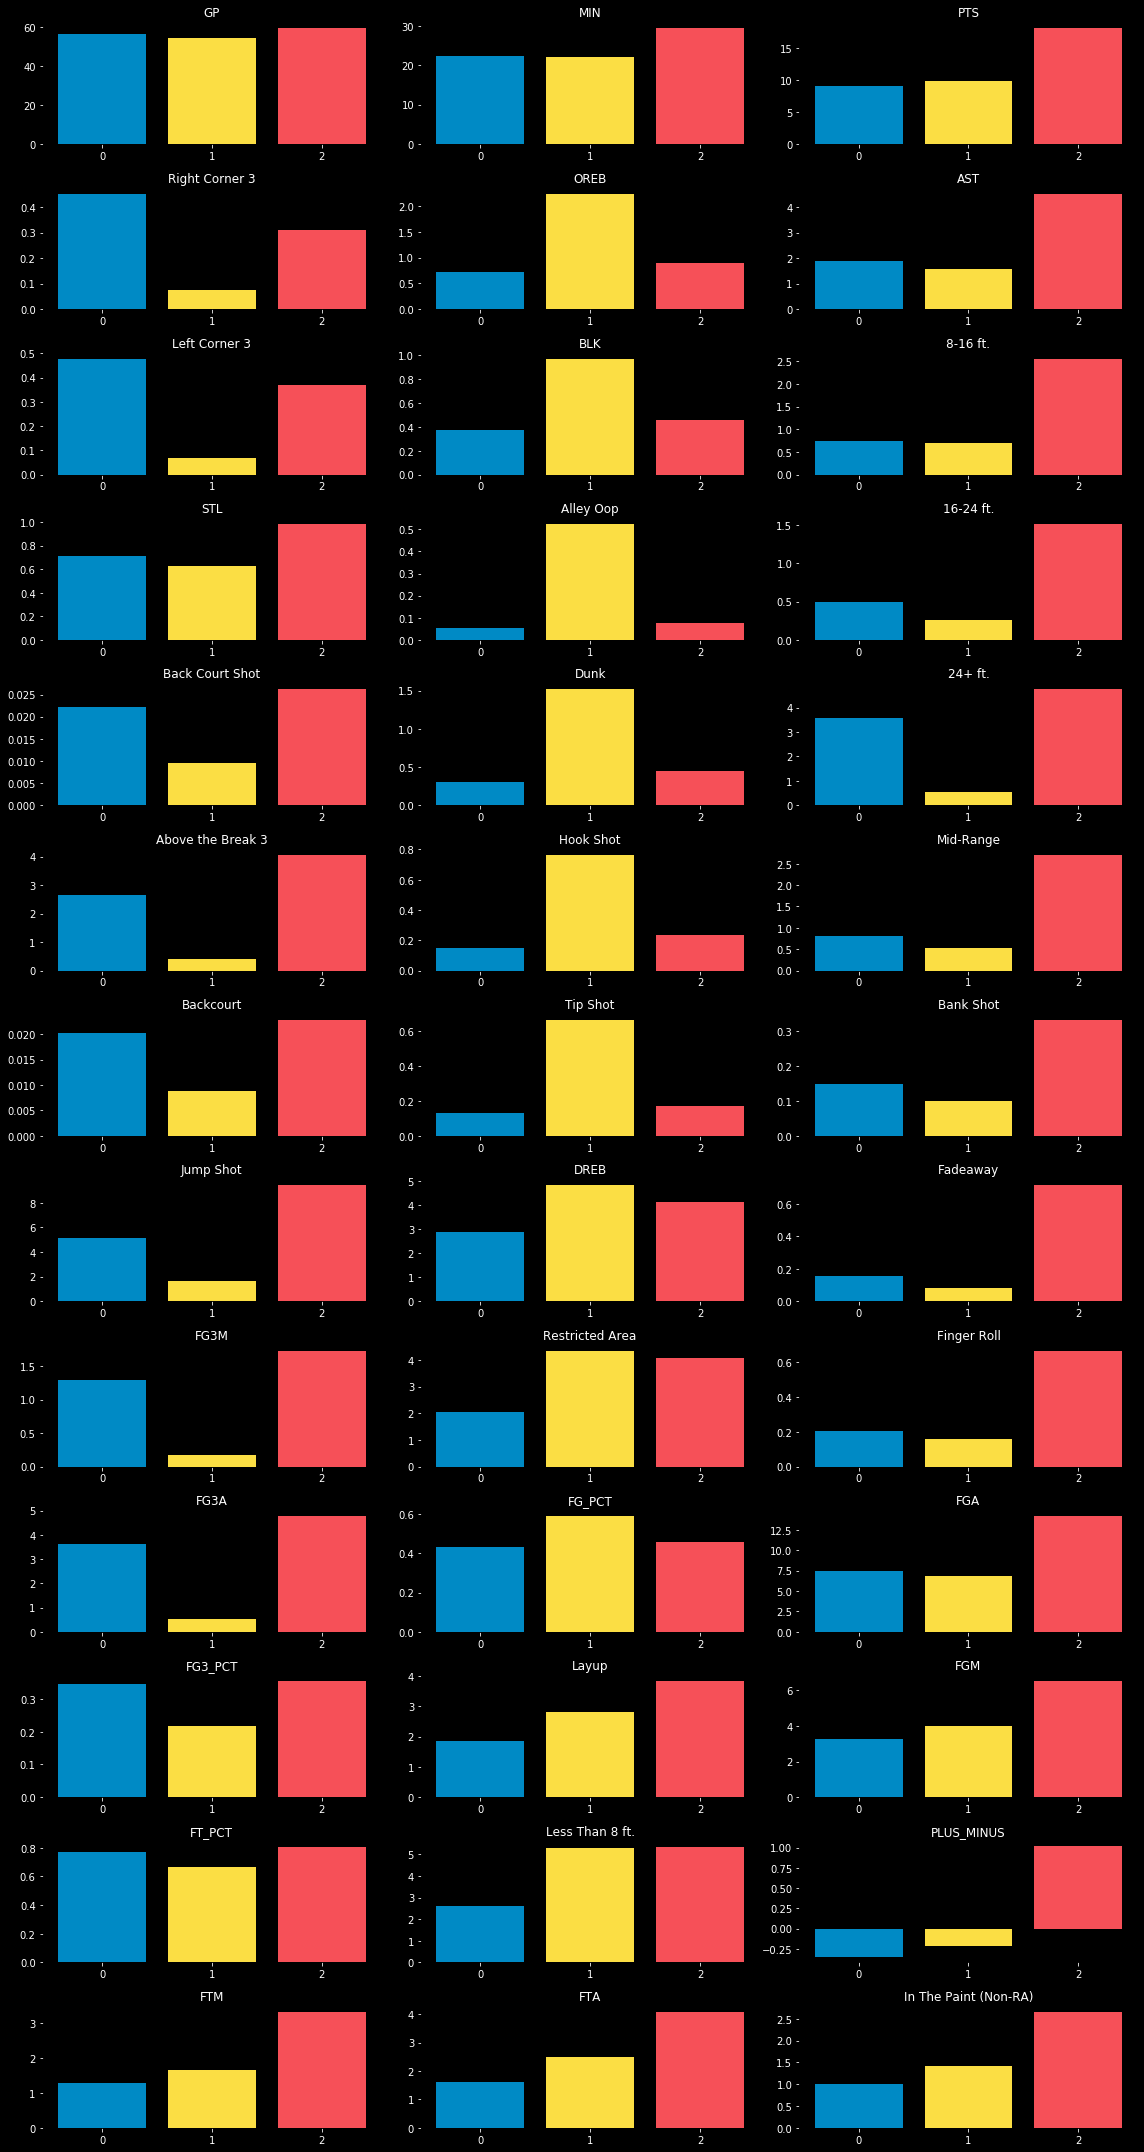

In [605]:
# Draw bar charts to compare clusters
#colors=['#D9514EFF', '#2A2B2DFF', '#2DA8D8FF']
colors=['#008AC5FF', '#FBDE44FF', '#F65058FF']

fig, axs = plt.subplots(13, 3, sharey=False, tight_layout=True, figsize=(16,30), facecolor='black')
coln=0

for i in range(0,13):
    for j in range(0,3):
        col=lst[coln]
        coln=coln+1
        # col=Player_summary_cl.columns[coln] - you can use this instead of creating a manual cols list
        axs[i,j].bar(Player_summary_cl['cluster'], height=Player_summary_cl[col], color=colors)
        axs[i,j].set(title=col)
        axs[i,j].set_facecolor('black')
        axs[i,j].set_xticks(ticks=(0,1,2), minor=False)
plt.show()

# END of Program